In [1]:
import numpy as np
import matplotlib.pyplot as plt
import supplementary_code as sc

from ipywidgets import interact
from matplotlib import cm

from scipy import ndimage as ndi
from scipy import stats

from skimage import (color, data, exposure, feature, filters, io, measure,
                    morphology, restoration, segmentation, transform,
                    util)

%matplotlib inline

In [2]:
data, rescaled, equalized = sc.results_from_part_1()

## Edge detection

[Edge detection](https://en.wikipedia.org/wiki/Edge_detection) highlights regions in the image where a sharp change in contrast occurs. The intensity of an edge corresponds to the steepness of the transition from one intensity to another. A gradual shift from bright to dark intensity results in a dim edge. An abrupt shift results in a bright edge.

The [Sobel operator](https://en.wikipedia.org/wiki/Sobel_operator) is an edge detection algorithm which approximates the gradient of the image intensity, and is fast to compute. `skimage.filters.sobel` has not been adapted for 3D images. It can be applied planewise to approximate a 3D result.

In [3]:
sobel = np.empty_like(rescaled)

for plane, image in enumerate(rescaled):
    sobel[plane] = filters.sobel(image)
    
sc.slice_explorer(sobel);

interactive(children=(IntSlider(value=30, description='plane', max=59), Output()), _dom_classes=('widget-inter…

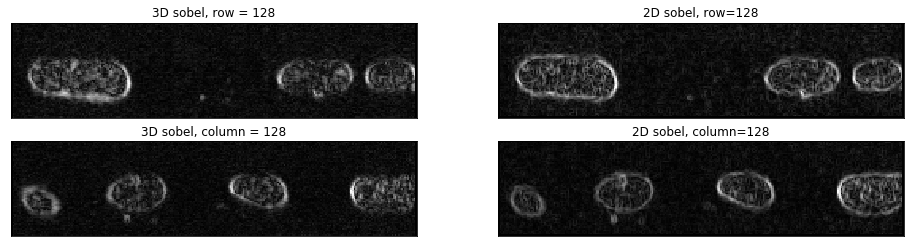

In [4]:
_, ((a, b), (c, d)) = plt.subplots(nrows=2, ncols=2, figsize=(16, 4))

sc.show_plane(a, sobel[:, 128, :], title='3D sobel, row = 128')

row_sobel = filters.sobel(rescaled[:, 128, :])
sc.show_plane(b, row_sobel, title='2D sobel, row=128')

sc.show_plane(c, sobel[:, :, 128], title='3D sobel, column = 128')

column_sobel = filters.sobel(rescaled[:, :, 128])
sc.show_plane(d, column_sobel, title='2D sobel, column=128')

The distance between pixels in each dimension, called `spacing`, is encoded in a tuple and is accepted as a parameter by some `skimage` functions and can be used to adjust contributions to filters.

The distance between pixels was reported by the microscope used to image the cells. This `spacing` information will be used to adjust contributions to filters and helps decide when to apply operations planewise. We've chosen to downsample each slice by a factor of 4 in the `row` and `column` dimensions to make the data smaller, thus reducing computational time. We also normalize it to `1.0` in the `row` and `column` dimensions.

In [5]:
# The microscope reports the following spacing:
original_spacing = np.array([0.2900000, 0.0650000, 0.0650000])
print('* Microscope original spacing: {}'.format(original_spacing))

# We downsampled each slice 4x to make the data smaller
rescaled_spacing = original_spacing * [1, 4, 4]
print('* Microscope after rescaling images: {}'.format(rescaled_spacing))

# Normalize the spacing so that pixels are a distance of 1 apart
spacing = rescaled_spacing / rescaled_spacing[2]
print('* Microscope normalized spacing: {}'.format(spacing))

* Microscope original spacing: [0.29  0.065 0.065]
* Microscope after rescaling images: [0.29 0.26 0.26]
* Microscope normalized spacing: [1.11538462 1.         1.        ]


We created the illustration below to illustrate the downsampling operation. The red dots show the pixels within each image.

Text(0.5, 1.0, 'Downsampled')

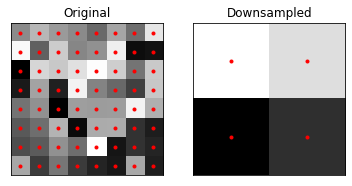

In [6]:
# To make sure we all see the same thing, let's set a seed
np.random.seed(0)

image = np.random.random((8, 8))
image_rescaled = transform.downscale_local_mean(image, (4, 4))

f, (ax0, ax1) = plt.subplots(1, 2)

ax0.imshow(image, cmap='gray')
ax0.set_xticks([])
ax0.set_yticks([])
centers = np.indices(image.shape).reshape(2, -1).T
ax0.plot(centers[:, 0], centers[:, 1], '.r')
ax0.set_title('Original')

ax1.imshow(image_rescaled, cmap='gray')
ax1.set_xticks([])
ax1.set_yticks([])
centers = np.indices(image_rescaled.shape).reshape(2, -1).T
ax1.plot(centers[:, 0], centers[:, 1], '.r');
ax1.set_title('Downsampled')

## Filters

In addition to edge detection, `skimage.filters` provides functions for filtering and thresholding images.

[Gaussian filter](https://en.wikipedia.org/wiki/Gaussian_filter) applies a Gaussian function to an image, creating a smoothing effect. `skimage.filters.gaussian` takes as input `sigma` which can be a scalar or a sequence of scalar. This `sigma` determines the standard deviation of the Gaussian along each axis. When the resolution in the `plane` dimension is much worse than the `row` and `column` dimensions, dividing `base_sigma` by the image `spacing` will balance the contribution to the filter along each axis.

In [7]:
base_sigma = 3.0

sigma = base_sigma / spacing

gaussian = filters.gaussian(rescaled, multichannel=False, sigma=sigma)

sc.slice_explorer(gaussian);

interactive(children=(IntSlider(value=30, description='plane', max=59), Output()), _dom_classes=('widget-inter…

[Median filter](https://en.wikipedia.org/wiki/Median_filter) is a noise removal filter. It is particularly effective against salt and pepper noise. An additional feature of the median filter is its ability to preserve edges. This is helpful in segmentation because the original shape of regions of interest will be preserved.

`skimage.filters.median` does not support three-dimensional images and needs to be applied planewise.

In [8]:
rescaled_uint8 = util.img_as_ubyte(rescaled)

median = np.empty_like(rescaled_uint8)

for plane, image in enumerate(rescaled_uint8):
    median[plane] = filters.median(image)
    
median = util.img_as_float(median)
    
sc.slice_explorer(median);

/Users/dani/anaconda3/envs/imagexd19/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


interactive(children=(IntSlider(value=30, description='plane', max=59), Output()), _dom_classes=('widget-inter…

A [bilateral filter](https://en.wikipedia.org/wiki/Bilateral_filter) is another edge-preserving, denoising filter. Each pixel is assigned a weighted average based on neighboring pixels. The weight is determined by spatial and radiometric similarity (e.g., distance between two colors).

`skimage.restoration.denoise_bilateral` requires a `multichannel` parameter. This determines whether the last axis of the image is to be interpreted as multiple channels or another spatial dimension. While the function does not yet support 3D data, the `multichannel` parameter will help distinguish multichannel 2D data from grayscale 3D data.

In [9]:
bilateral = np.empty_like(rescaled)

for index, plane in enumerate(rescaled):
    bilateral[index] = restoration.denoise_bilateral(
        plane, 
        multichannel=False
    )

sc.slice_explorer(bilateral);

interactive(children=(IntSlider(value=30, description='plane', max=59), Output()), _dom_classes=('widget-inter…

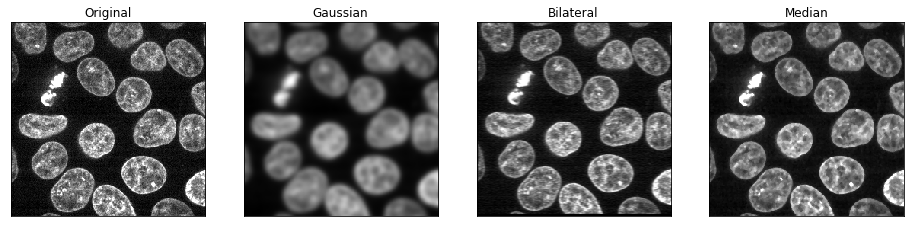

In [10]:
_, (a, b, c, d) = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

sc.show_plane(a, rescaled[32], title='Original')
sc.show_plane(b, gaussian[32], title='Gaussian')
sc.show_plane(c, bilateral[32], title='Bilateral')
sc.show_plane(d, median[32], title='Median')

In [11]:
denoised = median

## Thresholding

[Thresholding](https://en.wikipedia.org/wiki/Thresholding_%28image_processing%29) is used to create binary images. A threshold value determines the intensity value separating foreground pixels from background pixels. Foregound pixels are pixels brighter than the threshold value, background pixels are darker. Thresholding is a form of image segmentation.

Different thresholding algorithms produce different results. [Otsu's method](https://en.wikipedia.org/wiki/Otsu%27s_method) and Li's minimum cross entropy threshold are two common algorithms. The example below demonstrates how a small difference in the threshold value can visibly alter the binarized image.

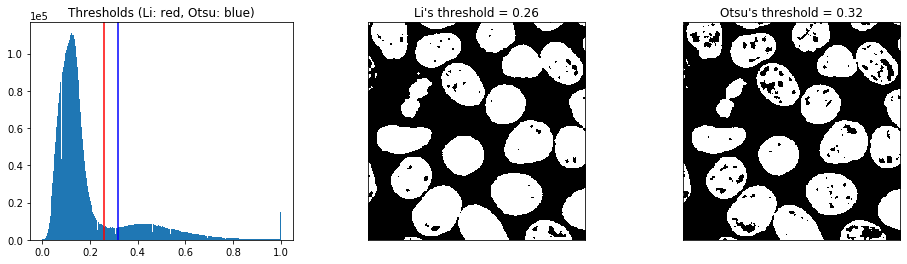

In [12]:
threshold_li = filters.threshold_li(denoised)
li = denoised >= threshold_li

threshold_otsu = filters.threshold_otsu(denoised)
otsu = denoised >= threshold_otsu

_, (a, b, c) = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

sc.plot_hist(a, denoised, 'Thresholds (Li: red, Otsu: blue)')
a.axvline(threshold_li, c='r')
a.axvline(threshold_otsu, c='b')

sc.show_plane(b, li[32], title='Li\'s threshold = {:0.2}'.format(threshold_li))
sc.show_plane(c, otsu[32], title='Otsu\'s threshold = {:0.2}'.format(threshold_otsu))

In [13]:
binary = li

sc.slice_explorer(binary)

interactive(children=(IntSlider(value=30, description='plane', max=59), Output()), _dom_classes=('widget-inter…

<function supplementary_code.slice_explorer.<locals>.display_slice(plane=30.0)>

## Morphological operations

[Mathematical morphology](https://en.wikipedia.org/wiki/Mathematical_morphology) operations and structuring elements are defined in `skimage.morphology`. Structuring elements are shapes which define areas over which an operation is applied. The response to the filter indicates how well the neighborhood corresponds to the structuring element's shape.

There are a number of two and three dimensional structuring elements defined in `skimage.morphology`. Not all 2D structuring element have a 3D counterpart. The simplest and most commonly used structuring elements are the `disk`/`ball` and `square`/`cube`.

In [14]:
ball = morphology.ball(radius=5)
print('* Ball shape: {}'.format(ball.shape))

cube = morphology.cube(width=5)
print('* Cube shape: {}'.format(cube.shape))

* Ball shape: (11, 11, 11)
* Cube shape: (5, 5, 5)


The most basic mathematical morphology operations are `dilation` and `erosion`. Dilation enlarges bright regions and shrinks dark regions. Erosion shrinks bright regions and enlarges dark regions. Other morphological operations are composed of `dilation` and `erosion`.

The `closing` of an image is defined as a `dilation` followed by an `erosion`. Closing can remove small dark spots (i.e. “pepper”) and connect small bright cracks. This tends to “close” up (dark) gaps between (bright) features. Morphological `opening` on an image is defined as an `erosion` followed by a `dilation`. Opening can remove small bright spots (i.e. “salt”) and connect small dark cracks. This tends to “open” up (dark) gaps between (bright) features.

These operations in `skimage.morphology` are compatible with 3D images and structuring elements. A 2D structuring element cannot be applied to a 3D image, nor can a 3D structuring element be applied to a 2D image.

These four operations (`closing`, `dilation`, `erosion`, `opening`) have binary counterparts which are faster to compute than the grayscale algorithms.

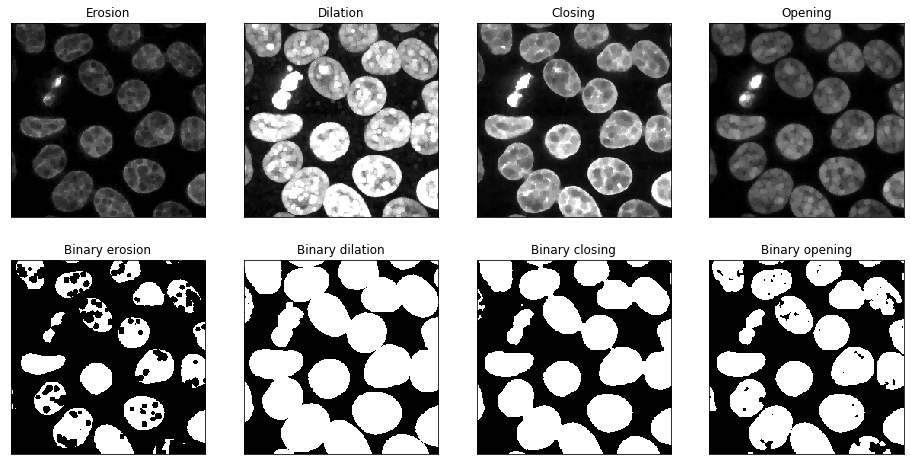

In [15]:
selem = morphology.ball(radius=3)

closing = morphology.closing(rescaled, selem=selem)
dilation = morphology.dilation(rescaled, selem=selem)
erosion = morphology.erosion(rescaled, selem=selem)
opening = morphology.opening(rescaled, selem=selem)

binary_closing = morphology.binary_closing(binary, selem=selem)
binary_dilation = morphology.binary_dilation(binary, selem=selem)
binary_erosion = morphology.binary_erosion(binary, selem=selem)
binary_opening = morphology.binary_opening(binary, selem=selem)

_, ((a, b, c, d), (e, f, g, h)) = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

sc.show_plane(a, erosion[32], title='Erosion')
sc.show_plane(b, dilation[32], title='Dilation')
sc.show_plane(c, closing[32], title='Closing')
sc.show_plane(d, opening[32], title='Opening')

sc.show_plane(e, binary_erosion[32], title='Binary erosion')
sc.show_plane(f, binary_dilation[32], title='Binary dilation')
sc.show_plane(g, binary_closing[32], title='Binary closing')
sc.show_plane(h, binary_opening[32], title='Binary opening')

Morphology operations can be chained together to denoise an image. For example, a `closing` applied to an `opening` can remove salt and pepper noise from an image.

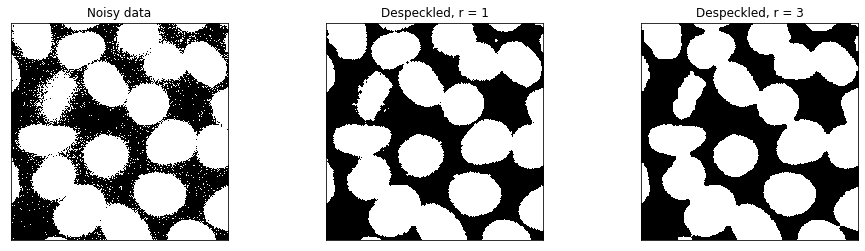

In [16]:
binary_equalized = equalized >= filters.threshold_li(equalized)

despeckled1 = morphology.closing(
    morphology.opening(binary_equalized, selem=morphology.ball(1)),
    selem=morphology.ball(1)
)

despeckled3 = morphology.closing(
    morphology.opening(binary_equalized, selem=morphology.ball(3)),
    selem=morphology.ball(3)
)

_, (a, b, c) = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

sc.show_plane(a, binary_equalized[32], title='Noisy data')
sc.show_plane(b, despeckled1[32], title='Despeckled, r = 1')
sc.show_plane(c, despeckled3[32], title='Despeckled, r = 3')

Functions operating on [connected components](https://en.wikipedia.org/wiki/Connected_space) can remove small undesired elements while preserving larger shapes.

`skimage.morphology.remove_small_holes` fills holes and `skimage.morphology.remove_small_objects` removes bright regions. Both functions accept a `min_size` parameter, which is the minimum size (in pixels) of accepted holes or objects. The `min_size` can be approximated by a cube.

In [17]:
width = 20

remove_holes = morphology.remove_small_holes(
    binary, 
    width ** 3
)

sc.slice_explorer(remove_holes);

interactive(children=(IntSlider(value=30, description='plane', max=59), Output()), _dom_classes=('widget-inter…

In [18]:
width = 20

remove_objects = morphology.remove_small_objects(
    remove_holes, 
    min_size=width ** 3
)

sc.slice_explorer(remove_objects);

interactive(children=(IntSlider(value=30, description='plane', max=59), Output()), _dom_classes=('widget-inter…

## Segmentation

[Image segmentation](https://en.wikipedia.org/wiki/Image_segmentation) partitions images into regions of interest. Integer labels are assigned to each region to distinguish regions of interest.

In [19]:
labels = measure.label(remove_objects)

sc.slice_explorer(labels, cmap='nipy_spectral');

interactive(children=(IntSlider(value=30, description='plane', max=59), Output()), _dom_classes=('widget-inter…

Connected components of the binary image are assigned the same label via `skimage.measure.label`. Tightly packed cells  connected in the binary image are assigned the same label.

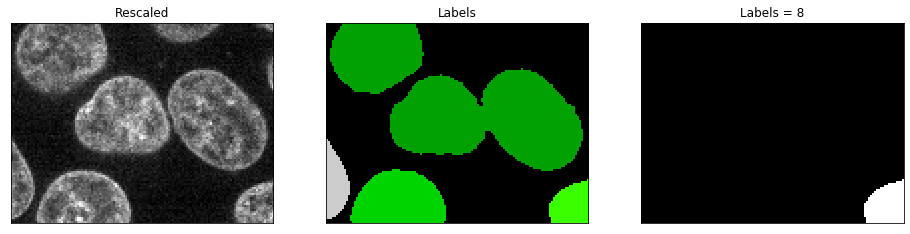

In [20]:
_, (a, b, c) = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

sc.show_plane(a, rescaled[32, :100, 125:], title='Rescaled')
sc.show_plane(b, labels[32, :100, 125:], cmap='nipy_spectral', title='Labels')
sc.show_plane(c, labels[32, :100, 125:] == 8, title='Labels = 8')

A better segmentation would assign different labels to disjoint regions in the original image. 

[Watershed segmentation](https://en.wikipedia.org/wiki/Watershed_%28image_processing%29) can distinguish touching objects. **Markers** are placed at local minima and expanded outward until there is a collision with markers from another region. The inverse intensity image transforms bright cell regions into basins which should be filled.

In declumping, markers are generated from the distance function. Points furthest from an edge have the highest intensity and should be identified as markers using `skimage.feature.peak_local_max`. Regions with pinch points should be assigned multiple markers.

In [21]:
distance = ndi.distance_transform_edt(remove_objects)

sc.slice_explorer(distance, cmap='viridis');

interactive(children=(IntSlider(value=30, description='plane', max=59), Output()), _dom_classes=('widget-inter…

In [22]:
peak_local_max = feature.peak_local_max(
    distance,
    footprint=np.ones((15, 15, 15), dtype=np.bool),
    indices=False,
    labels=measure.label(remove_objects)
)

markers = measure.label(peak_local_max)

labels = morphology.watershed(
    rescaled, 
    markers, 
    mask=remove_objects
)

sc.slice_explorer(labels, cmap='inferno');

interactive(children=(IntSlider(value=30, description='plane', max=59), Output()), _dom_classes=('widget-inter…

After watershed, we have better disambiguation between internal cells.

When cells simultaneous touch the border of the image, they may be assigned the same label.  In pre-processing, we typically remove these cells.

*Note:* This is 3D data---you may not always be able to see connections in 2D!

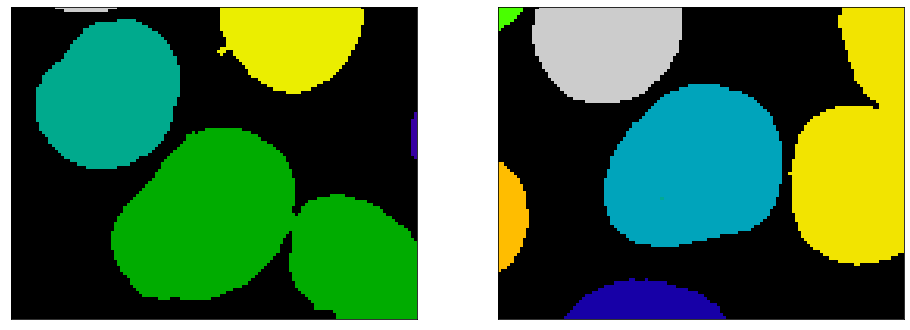

In [23]:
_, (a, b) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

sc.show_plane(a, labels[39, 156:, 20:150], cmap='nipy_spectral')
sc.show_plane(b, labels[34, 90:190, 126:], cmap='nipy_spectral')

The watershed algorithm falsely detected subregions in a few cells. This is referred to as oversegmentation.

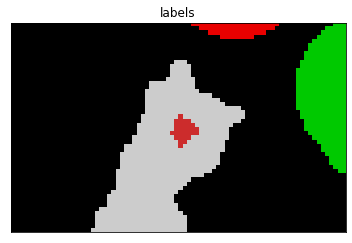

In [24]:
f, ax = plt.subplots()
sc.show_plane(ax, labels[38, 50:100, 20:100], cmap='nipy_spectral', title='labels')

Plotting the markers on the distance image reveals the reason for oversegmentation. Cells with multiple markers will be assigned multiple labels, and oversegmented. It can be observed that cells with a uniformly increasing distance map are assigned a single marker near their center. Cells with uneven distance maps are assigned multiple markers, indicating the presence of multiple local maxima.

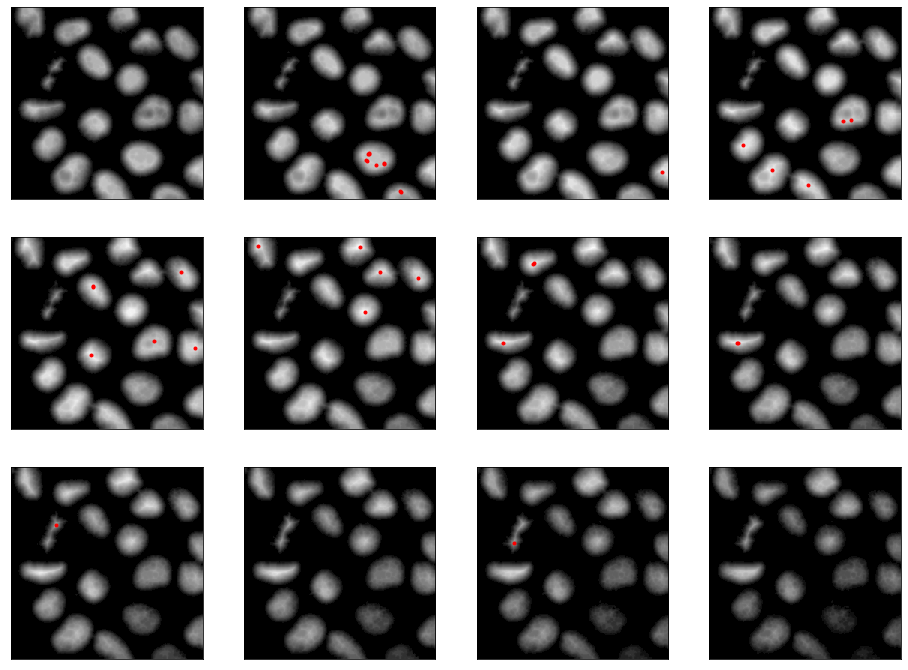

In [25]:
_, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))

vmin = distance.min()
vmax = distance.max()

offset = 31

for index, ax in enumerate(axes.flatten()):
    ax.imshow(
        distance[offset + index],
        cmap='gray',
        vmin=vmin,
        vmax=vmax
    )
    
    peaks = np.nonzero(peak_local_max[offset + index])
    
    ax.plot(peaks[1], peaks[0], 'r.')
    ax.set_xticks([])
    ax.set_yticks([])

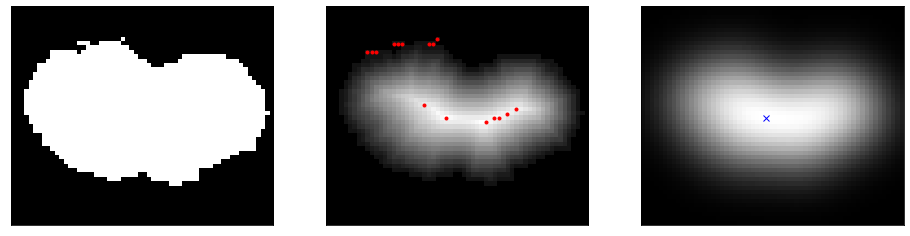

In [26]:
_, (a, b, c) = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))


sc.show_plane(a, remove_objects[10:, 193:253, 74])
sc.show_plane(b, distance[10:, 193:253, 74])

features = feature.peak_local_max(distance[10:, 193:253, 74])
b.plot(features[:, 1], features[:, 0], 'r.')

# Improve feature selection by blurring, using a larger footprint
# in `peak_local_max`, etc.

smooth_distance = filters.gaussian(distance[10:, 193:253, 74], sigma=5)
sc.show_plane(c, smooth_distance)
features = feature.peak_local_max(
    smooth_distance
)
c.plot(features[:, 1], features[:, 0], 'bx');

## Cleaning before Feature extraction

[Feature extraction](https://en.wikipedia.org/wiki/Feature_extraction) reduces data required to describe an image or objects by measuring informative features. These include features such as area or volume, bounding boxes, and intensity statistics.

Before measuring objects, it helps to clear objects from the image border. Measurements should only be collected for objects entirely contained in the image.

In [27]:
interior_labels = segmentation.clear_border(labels)
interior_labels = morphology.remove_small_objects(interior_labels, min_size=200)

print('interior labels: {}'.format(np.unique(interior_labels)))

sc.slice_explorer(interior_labels, cmap='inferno');

interior labels: [ 0  3  7  9 13 16 21 22 23 24]


interactive(children=(IntSlider(value=30, description='plane', max=59), Output()), _dom_classes=('widget-inter…

After clearing the border, the object labels are no longer sequentially increasing. The labels can be renumbered such that there are no jumps in the list of image labels:

In [28]:
relabeled, _, _ = segmentation.relabel_sequential(interior_labels)

print('Relabeled labels: {}'.format(np.unique(relabeled)))

Relabeled labels: [0 1 2 3 4 5 6 7 8 9]


This result is likely to be used for comparison with results of other algorithms, so let's learn how to save multi-tiffs: 

In [30]:
from skimage.external import tifffile
outfile = 'data/cells_interior_labels.tiff'
tifffile.imsave(outfile, relabeled)

## Measurements

`skimage.measure.regionprops` automatically measures many labeled image features. Optionally, an `intensity_image` can be supplied and intensity features are extracted per object. It's good practice to make measurements on the original image.

Not all properties are supported for 3D data. Below are lists of supported and unsupported 3D measurements.

In [31]:
regionprops = measure.regionprops(relabeled, intensity_image=data)

supported = [''] 
unsupported = ['']

for prop in regionprops[0]:
    try:
        regionprops[0][prop]
        supported.append(prop)
    except NotImplementedError:
        unsupported.append(prop)

print('Supported properties:')
print('\n\t'.join(supported))
print()
print('Unsupported properties:')
print('\n\t'.join(unsupported))

Supported properties:

	area
	bbox
	bbox_area
	centroid
	convex_area
	convex_image
	coords
	equivalent_diameter
	euler_number
	extent
	filled_area
	filled_image
	image
	label
	major_axis_length
	max_intensity
	mean_intensity
	min_intensity
	minor_axis_length
	moments
	moments_central
	moments_normalized
	slice
	solidity
	weighted_centroid
	weighted_moments
	weighted_moments_central
	weighted_moments_normalized

Unsupported properties:

	eccentricity
	moments_hu
	orientation
	perimeter
	weighted_moments_hu


`skimage.measure.regionprops` ignores the 0 label, which represents the background.

In [32]:
print('Measured regions: {}'.format([regionprop.label for regionprop in regionprops]))

Measured regions: [1, 2, 3, 4, 5, 6, 7, 8, 9]


In [33]:
volumes = [regionprop.area for regionprop in regionprops]

print('total pixels: {}'.format(volumes))

total pixels: [48806, 47480, 40182, 40516, 42496, 40032, 37450, 48160, 204]


Collected measurements can be further reduced by computing per-image statistics such as total, minimum, maximum, mean, and standard deviation.

In [34]:
max_volume = np.max(volumes)
mean_volume = np.mean(volumes)
min_volume = np.min(volumes)
sd_volume = np.std(volumes)
total_volume = np.sum(volumes)

print('Volume statistics')
print('total: {}'.format(total_volume))
print('min: {}'.format(min_volume))
print('max: {}'.format(max_volume))
print('mean: {:0.2f}'.format(mean_volume))
print('standard deviation: {:0.2f}'.format(sd_volume))

Volume statistics
total: 345326
min: 204
max: 48806
mean: 38369.56
standard deviation: 14035.32
